1. Engine thrust lapse (TOC/TO) and (TOC/00)
2. Specific thrust at TOC vs. specific thrust at TO
3. Rate of specific thrust with TS

In [1]:
# Imports 
import os
import sys
sys.path.append("..")
os.environ["pyna_language"] = 'python'
import pdb
import numpy as np
import openmdao.api as om
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
%matplotlib inline
from pyNA.pyna import pyna
from scipy import interpolate

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Definitions 
class Constants:
    """
    
    """

    def __init__(self):
        
        # Constants
        self.gamma = 1.4               # Ratio of specific heats [-]
        self.R = 287.                  # Gas constant air [J/kgK]
        self.Cp = self.gamma*self.R/(self.gamma-1)  # Specific heat at constant pressure [J/kgK]
        self.g = 9.80665               # Gravitational acceleration [m/s2]

        # Fuel constants
        self.LHV = 43e6                # Kerosene lower heating value [J/kg]

        # Sea level values of atmosphere
        self.rho_sl   = 1.225          # Sea level density [kg/m3]
        self.P_sl     = 101325         # Sea level pressure [Pa]
        self.T_sl     = 288.15         # Sea level temperature [K]
        self.lapse_sl = 0.0065         # Lapse rate troposphere [1/m]

        # z = 11km values of atmosphere
        self.rho_z11 = 0.363918       # h = 11km density [kg/m3]
        self.P_z11   = 22632.1        # h = 11km pressure [kg/m3]
        self.T_z11   = 216.65         # h = 11km temperature [kg/m3]

        # z = 20 values of atmosphere
        self.rho_z20   = 0.0880349    # Sea level density [kg/m3]
        self.P_z20     = 5474.89      # Sea level pressure [Pa]
        self.T_z20     = 216.650      # Sea level temperature [K]
        self.lapse_z20 = -0.0001      # Lapse rate troposphere [1/m]
        
class ACD:
    """
    The Aircraft Conceptual Design (ACD) module contains the methods for the conceptual design of aircraft from first principles.
    
    """

    def __init__(self) -> None:
        
        """
        :param mtow: maximum take-off weight [kg]
        :type mtow: float
        :param M_0: cruise Mach number [-]
        :type M_0: float
        :param N_e: number of engines [-]
        :type N_e: int
        """

        self.c = Constants()

    def compute_atmosphere(self, z): 
        """
        Calculate atmospheric properties at altitude z.
        
        :param z: altitude [m]
        :type z: np.ndarray
        
        :return: [T, p, rho, a]
        :rtype: list
        """
        
        ## Calculations
        T = np.zeros(np.size(z))
        rho = np.zeros(np.size(z))
        p = np.zeros(np.size(z))
        a = np.zeros(np.size(z))
        
        if np.size(z) == 1:
            z = [z]
        
        for i, height in enumerate(z):
            # Troposphere
            if height >= -100. and height <= 11000.:
                T[i]   = self.c.T_sl - self.c.lapse_sl*height
                p[i]   = self.c.P_sl * (T[i]/self.c.T_sl)**(self.c.g/self.c.lapse_sl/self.c.R)
                rho[i] = self.c.rho_sl * (T[i]/self.c.T_sl)**(self.c.g/self.c.lapse_sl/self.c.R-1)
            # Tropopause
            elif height > 11000. and height < 20000.: 
                T[i]   = self.c.T_z11
                p[i]   = self.c.P_z11 * np.exp(-self.c.g*(height-11000)/self.c.R/T[i])
                rho[i] = self.c.rho_z11 * np.exp(-self.c.g*(height-11000)/self.c.R/T[i])
            # Stratosphere
            elif height >=20000. and height < 32000:
                T[i]   = self.c.T_z20 - self.c.lapse_z20*(height-20000)   
                p[i]   = self.c.P_z20 * (T[i]/self.c.T_z20)**(self.c.g/self.c.lapse_z20/self.c.R)
                rho[i] = self.c.rho_z20 * (T[i]/self.c.T_z20)**(self.c.g/self.c.lapse_z20/self.c.R-1)
            else:
                raise ValueError('Altitude is out of bounds (-100 < z < 32000) m.')

            a[i] = np.sqrt(self.c.gamma*self.c.R*T[i])
        
        if np.size(z) == 1:
            return T[0], p[0], rho[0], a[0]
        else:
            return T, p, rho, a
        
acd = ACD()

In [3]:
# Sweeps (STCA) / (GT Medium SST) 
W_S_lst = np.linspace(3500, 5000, 7)
F_W_lst = np.linspace(0.325, 0.475, 7)

case_lst = ['base', 'ld6', 'ld13', 'clmax', 'all_constant_LD6', 'all_constant_LD12', 'EA_constant_LD6', 'EA_constant_LD6']
clmax_lst = dict()
LDmax_lst = dict()
for k,case in enumerate(case_lst):
    clmax_lst[case] = np.array([1.2, 1.2, 1.2, 1.452528, 1.2, 1.2, 1.2, 1.2])[k]
    LDmax_lst[case] = np.array([6.718101501415649, 6.718101501415649, 2*6.718101501415649, 6.718101501415649, 6.718101501415649, 2*6.718101501415649, 6.718101501415649, 2*6.718101501415649])[k]

In [4]:
# Compute trajectories for (z-TS) sweep 
if False:
    ac_name = 'stca'
    case = 'EA_constant_LD6'
    
    for W_S in W_S_lst:    
        for F_W in F_W_lst:

            W = 55000*9.81

            c_l_max = clmax_lst[case]
            v_stall = np.sqrt(2*W_S/1.225/c_l_max)
            v_max = 1.4*v_stall

            pyna_settings = pyna.load_settings(case_name=ac_name)
            pyna_settings.ac_name = ac_name
            pyna_settings.case_name = ac_name
            pyna_settings.engine_file_name = 'engine_deck_' + ac_name + '.csv'
            pyna_settings.save_results = True
            pyna_settings.output_directory_name = 'scaling_EA_constant_LD6'
            pyna_settings.max_iter = 100
            pyna_settings.TS_to = 1.0
            pyna_settings.TS_vnrs = 1.0
            pyna_settings.PKROT = True
            pyna_settings.engine_thrust_lapse = False
            pyna_settings.atmosphere_type = 'sealevel'

            pyna_settings.theta_flaps = 10.
            pyna_settings.theta_slats = -6.

            # pyna_settings.theta_flaps = 26.
            # pyna_settings.theta_slats = -26.

            pyna_settings.TS_cutback = 1.
            pyna_settings.z_cutback = 405.
            pyna_settings.output_file_name = pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.sql'

            pyna_settings.Foo = F_W*W/3

            # Compute trajectory
            py = pyna(pyna_settings)
            py.ac.v_max = v_max

            py.ac.af_S_w = W/W_S

            converged = py.compute_trajectory(trajectory_mode='cutback', objective='t_end')

            # Save timeseries
            path_save_name = 'trajectory_' + pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'
            engine_save_name = 'engine_' + pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'
            py.save_time_series(py.problem, py.settings, py.ac, path_save_name, engine_save_name)

In [5]:
# Load trajectories 
ac_name = 'stca'
pyna_settings = pyna.load_settings(case_name=ac_name)
pyna_settings.ac_name = ac_name

data = dict()

for k, case in enumerate(case_lst): 
    
    data[case] = dict()
    
    for W_S in W_S_lst:

        data[case][W_S] = dict()

        for F_W in F_W_lst:

            if case == 'base':
                pyna_settings.output_directory_name = 'scaling'
                pyna_settings.output_file_name = pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.sql'
                pyna_settings.engine_file_name = 'engine_' + pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'
                pyna_settings.trajectory_file_name = 'trajectory_' + pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'

                data[case][W_S][F_W] = pd.read_csv('../cases/'+ac_name+'/trajectory/scaling/'+pyna_settings.trajectory_file_name)

            if case == 'ld6':
                pyna_settings.output_directory_name = 'scaling_LD6'
                pyna_settings.output_file_name = pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.sql'
                pyna_settings.engine_file_name = 'engine_' + pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'
                pyna_settings.trajectory_file_name = 'trajectory_' + pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'

                data[case][W_S][F_W] = pd.read_csv('../cases/'+ac_name+'/trajectory/scaling_LD6/'+pyna_settings.trajectory_file_name)

            if case == 'ld13':
                pyna_settings.output_directory_name = 'scaling_LD12'
                pyna_settings.output_file_name = pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.sql'
                pyna_settings.engine_file_name = 'engine_' + pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'
                pyna_settings.trajectory_file_name = 'trajectory_' + pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'

                data[case][W_S][F_W] = pd.read_csv('../cases/'+ac_name+'/trajectory/scaling_LD12/'+pyna_settings.trajectory_file_name)

            if case == 'clmax':
                pyna_settings.output_directory_name = 'scaling_clmax'
                pyna_settings.output_file_name = pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.sql'
                pyna_settings.engine_file_name = 'engine_' + pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'
                pyna_settings.trajectory_file_name = 'trajectory_' + pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'

                data[case][W_S][F_W] = pd.read_csv('../cases/'+ac_name+'/trajectory/scaling_clmax/'+pyna_settings.trajectory_file_name)

            if case == 'all_constant_LD6':
                pyna_settings.output_directory_name = 'scaling_all_constant_LD6'
                pyna_settings.output_file_name = pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.sql'
                pyna_settings.engine_file_name = 'engine_' + pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'
                pyna_settings.trajectory_file_name = 'trajectory_' + pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'

                data[case][W_S][F_W] = pd.read_csv('../cases/'+ac_name+'/trajectory/scaling_all_constant_LD6/'+pyna_settings.trajectory_file_name)
                
            if case == 'all_constant_LD12':
                pyna_settings.output_directory_name = 'scaling_all_constant_LD12'
                pyna_settings.output_file_name = pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.sql'
                pyna_settings.engine_file_name = 'engine_' + pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'
                pyna_settings.trajectory_file_name = 'trajectory_' + pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'

                data[case][W_S][F_W] = pd.read_csv('../cases/'+ac_name+'/trajectory/scaling_all_constant_LD12/'+pyna_settings.trajectory_file_name)
                
                
            if case == 'EA_constant_LD6':
                pyna_settings.output_directory_name = 'scaling_EA_constant_LD6'
                pyna_settings.output_file_name = pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.sql'
                pyna_settings.engine_file_name = 'engine_' + pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'
                pyna_settings.trajectory_file_name = 'trajectory_' + pyna_settings.ac_name + '_WS' + str(np.round(W_S)) + '_F_W' + str(np.round(F_W,3))+ '.csv'

                data[case][W_S][F_W] = pd.read_csv('../cases/'+ac_name+'/trajectory/scaling_EA_constant_LD6/'+pyna_settings.trajectory_file_name)
                

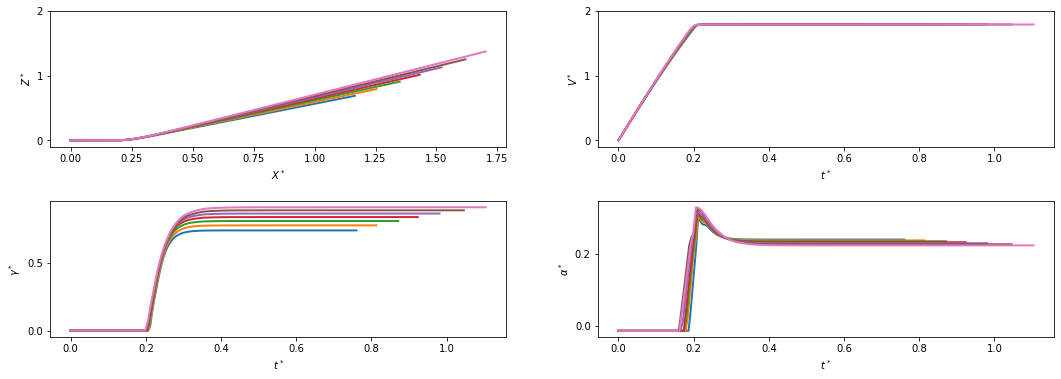

In [6]:
# Plot scaled trajectories 
if True:
    fig, ax = plt.subplots(2,2, figsize=(18, 6))
    plt.style.use('../utils/plot.mplstyle')

    scaling = True

    for case in ['EA_constant_LD6']:

        for i,W_S in enumerate([W_S_lst[-1]]):
            for j,F_W in enumerate(F_W_lst):

                if scaling:
                    x_group     = F_W / W_S * clmax_lst[case]
                    t_group     = F_W / np.sqrt(W_S/clmax_lst[case])
                    z_group     = F_W / W_S * clmax_lst[case]/(F_W-1/LDmax_lst[case])
                    v_group     = 1/np.sqrt(W_S/clmax_lst[case])
                    gamma_group = (np.pi/180)/(F_W-1/LDmax_lst[case])
                    alpha_group = (np.pi/180)
                else:
                    x_group     = 1.
                    t_group     = 1.
                    z_group     = 1.
                    v_group     = 1.
                    gamma_group = 1.
                    alpha_group = 1.  

                ax[0,0].plot(data[case][W_S][F_W]['X [m]'].values*x_group, data[case][W_S][F_W]['Z [m]'].values*z_group)
                ax[0,1].plot(data[case][W_S][F_W]['t_source [s]'].values*t_group, data[case][W_S][F_W]['V [m/s]'].values*v_group)
                ax[1,0].plot(data[case][W_S][F_W]['t_source [s]'].values*t_group, data[case][W_S][F_W]['gamma [deg]'].values*gamma_group)
                ax[1,1].plot(data[case][W_S][F_W]['t_source [s]'].values*t_group, data[case][W_S][F_W]['alpha [deg]'].values*alpha_group)
                
#                 ax[0,0].plot([0, 0.2, 2], [0, 0, np.tan(0.812)*(2-0.2)], 'k--')
#                 ax[0,0].plot([0, 0.25, 2], [0, 0, np.tan(0.85*0.812)*(2-0.25)], 'k--')
#                 ax[1,0].plot([0,1.3], [1, 1], 'k--')
#                 ax[0,2].plot(data[case][W_S][F_W]['t_source [s]'].values*t_group, data[case][W_S][F_W]['TS [-]'].values)
#                 ax[1,2].plot(data[case][W_S][F_W]['t_source [s]'].values*t_group, data[case][W_S][F_W]['F_n [N]'].values/data[case][W_S][F_W]['F_n [N]'].values[0])
    
        if scaling:
            ax[0,0].set_xlabel('$X^*$')
            ax[0,0].set_ylabel('$Z^*$')
            ax[0,0].set_ylim([-0.1, 2])
            ax[0,1].set_xlabel('$t^*$')
            ax[0,1].set_ylabel('$V^*$')
            ax[0,1].set_ylim([-0.1, 2])
            ax[1,0].set_xlabel('$t^*$')
            ax[1,0].set_ylabel(r'$\gamma^*$')
            ax[1,1].set_xlabel('$t^*$')
            ax[1,1].set_ylabel(r'$\alpha^*$')
        else:
            ax[0,0].set_xlabel('$X$ [m]')
            ax[0,0].set_ylabel('$Z$ [m]')
            ax[0,1].set_xlabel('$t$ [s]')
            ax[0,1].set_ylabel('$V$ [m/s]')
            ax[1,0].set_xlabel('$t$ [s]')
            ax[1,0].set_ylabel(r'$\gamma$ [deg]')
            ax[1,1].set_xlabel('$t$ [s]')
            ax[1,1].set_ylabel(r'$\alpha$ [deg]')
            
        plt.subplots_adjust(hspace=0.4)

In [7]:
# Compute minimum distance between microphone and trajectory 
r_min = dict()

for k,case in enumerate(case_lst): 
    
    r_min[case] = np.zeros((np.size(W_S_lst),np.size(F_W_lst)))
    
    for i,W_S in enumerate(W_S_lst):
        for j,F_W in enumerate(F_W_lst):
    
            # Compute distance to flyover microphone
            dist = np.sqrt((data[case][W_S][F_W]['X [m]'].values-6500)**2+(data[case][W_S][F_W]['Z [m]'].values-0)**2)
            r_min[case][i,j] = np.min(dist)

/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in arcsin
  


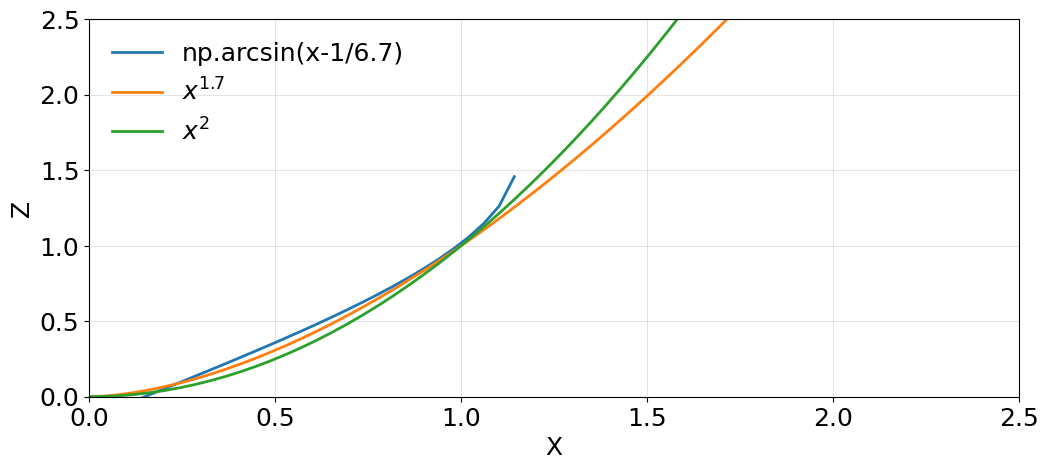

In [8]:
x = np.linspace(0, 2)
plt.plot(x, np.arcsin(x-1/6.7), label='np.arcsin(x-1/6.7)')
plt.plot(x, x**1.7, label='$x^{1.7}$')
plt.plot(x, x**2, label='$x^{2}$')
plt.xlim([0,2.5])
plt.ylim([0,2.5])
plt.xlabel('X')
plt.ylabel('Z')
plt.legend(frameon=False)

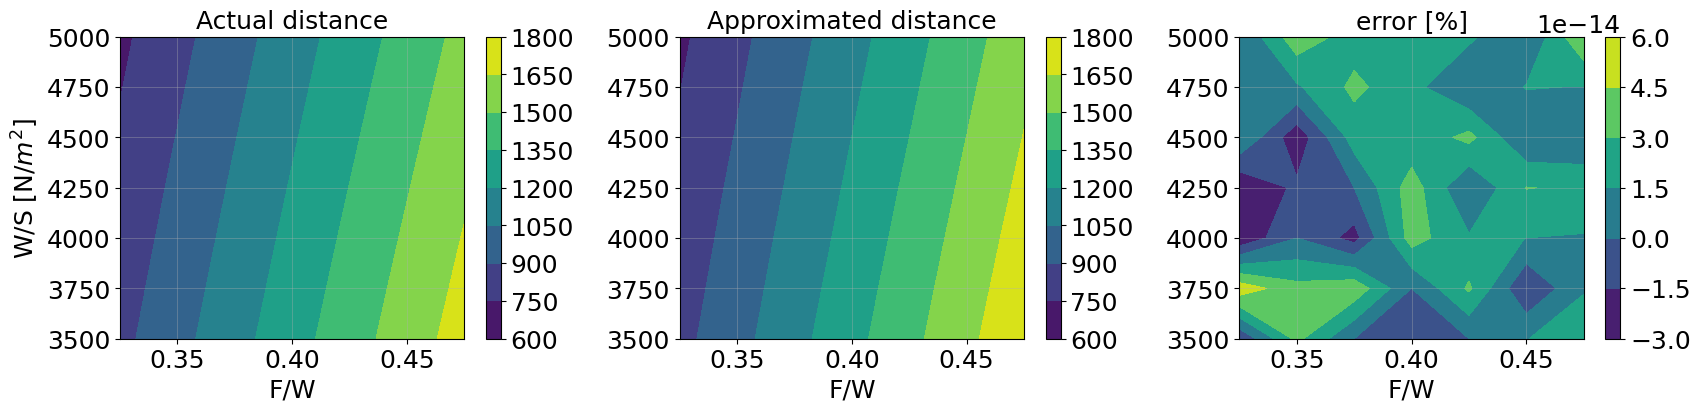

In [12]:
# Reduced order model 1
def solution_d(f, w, c, l, ppp, r, g):
    
    a = f / w * c
    b = f / w * c/(f-1/l)
    p = ppp/a
    
    d = np.sqrt( (r - (r*b**2*g**2 - p*a**2*g**2 + p*a**2)/(b**2*g**2 - a**2*g**2 + a**2))**2 - (a**2*b**2*g**2*(p - r)**2*(g - 1)*(g + 1))/(b**2*g**2 - a**2*g**2 + a**2)**2 )

    return d

def solution_d_new(f, w, c, l, ppp, r, g):
        
    d_new = (r*f*c-ppp*w)/(f*c) * np.sqrt( (1-g**2)*(f*l-1)**2/((1-g**2)*(f*l-1)**2+l**2*g**2) )

#     k = 1/(l*g)*np.sqrt(1-g**2)
#     d_new = (r-ppp*w/(f*c))*(f*l-1) * k
#     d_new = k * (r*f*l - ppp*w*l/c - r)
            
    return d_new

d_sol = dict()
d_sol_n = dict()

for k,case in enumerate(case_lst):
    
    d_sol[case] = np.zeros((np.size(W_S_lst), np.size(F_W_lst)))
    d_sol_n[case] = np.zeros((np.size(W_S_lst), np.size(F_W_lst)))
    
    for i,WS in enumerate(W_S_lst):
        for j,FW in enumerate(F_W_lst):
            
            d_sol[case][i,j] = solution_d(FW, WS, clmax_lst[case], LDmax_lst[case], 0.2, 6500., np.cos(0.8124))
            d_sol_n[case][i,j] = solution_d_new(FW, WS, clmax_lst[case], LDmax_lst[case], 0.2, 6500., np.cos(0.8124))

fig, ax = plt.subplots(1,3, figsize=(20, 4))
c0 = ax[0].contourf(F_W_lst, W_S_lst, d_sol['all_constant_LD6'])
plt.colorbar(c0, ax=ax[0])
ax[0].set_title('Actual distance')
ax[0].set_xlabel('F/W')
ax[0].set_ylabel('W/S [N/$m^2$]')

c1 = ax[1].contourf(F_W_lst, W_S_lst, r_min['all_constant_LD6'])
plt.colorbar(c1, ax=ax[1])
ax[1].set_title('Approximated distance')
ax[1].set_xlabel('F/W')

c1 = ax[2].contourf(F_W_lst, W_S_lst, 100*(d_sol_n['all_constant_LD6']-d_sol['all_constant_LD6'])/d_sol['all_constant_LD6'])
plt.colorbar(c1, ax=ax[2])
ax[2].set_title('error [%]')
ax[2].set_xlabel('F/W')

plt.subplots_adjust(wspace=0.3)

In [11]:
# Reduced order model
r_min_ro_1 = dict()
r_min_ro_2 = dict()

r_min_simple1 = dict()
r_min_simple2 = dict()

for i,case in enumerate(case_lst):

    FW, WS = np.meshgrid(F_W_lst, W_S_lst)

    x_group = FW / WS * clmax_lst[case]
    z_group = clmax_lst[case]/(FW*WS) / np.sqrt(LDmax_lst[case])

    xr = 6500.0

    gamma_pp = 0.38
    xp_pp = 0.22

    quad_A = 1 + (1-np.cos(gamma_pp)**2)/np.cos(gamma_pp)**2 * x_group**2 /z_group**2
    quad_B = -(xp_pp/x_group+x_group/z_group*2*xp_pp*np.sqrt(1-np.cos(gamma_pp)**2)/np.cos(gamma_pp) + xr)
    quad_C = xp_pp/x_group*xr + xp_pp**2*(1-np.cos(gamma_pp)**2)/np.cos(gamma_pp)**2/z_group

    x_s1 = (- quad_B + np.sqrt(quad_B**2 - 4*quad_A*quad_C)) / (2*quad_A)
    x_s2 = (- quad_B - np.sqrt(quad_B**2 - 4*quad_A*quad_C)) / (2*quad_A)

    z_s1 = (x_group*x_s1 - xp_pp)*np.sqrt(1-np.cos(gamma_pp)**2)/z_group/np.cos(gamma_pp)
    z_s2 = (x_group*x_s2 - xp_pp)*np.sqrt(1-np.cos(gamma_pp)**2)/z_group/np.cos(gamma_pp)

    r_min_ro_1[case] = np.sqrt((x_s1-xr)**2+(z_s1)**2)
    r_min_ro_2[case] = np.sqrt((x_s2-xr)**2+(z_s2)**2)

    s_pp = xr*FW/(WS/clmax_lst[case])-xp_pp 
    r_min_simple1[case] = np.sqrt((s_pp*np.sin(gamma_pp)*np.cos(gamma_pp)/(clmax_lst[case]/FW/WS*np.sqrt(LDmax_lst[case])))**2 + (s_pp*np.sin(gamma_pp)**2/(FW/(WS/clmax_lst[case])))**2 )
    r_min_simple2[case] = 8*np.sqrt((s_pp*np.sin(gamma_pp)*np.cos(gamma_pp)/(clmax_lst[case]/FW/WS*np.sqrt(LDmax_lst[case])))**2 )
    

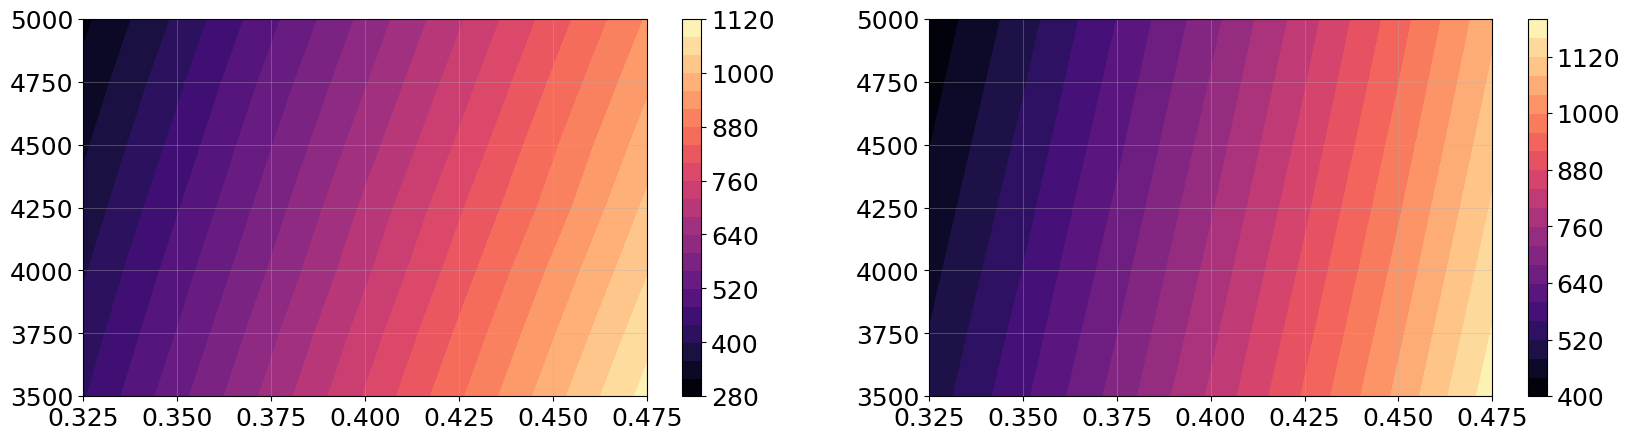

In [13]:
case = 'base'

fig, ax = plt.subplots(1, 2,figsize=(20,5))

c0 = ax[0].contourf(F_W_lst, W_S_lst, r_min[case], levels=20, cmap='magma')
cbar = plt.colorbar(c0, ax=ax[0])

c0 = ax[1].contourf(F_W_lst, W_S_lst, r_min_ro_1[case], levels=20, cmap='magma')
cbar = plt.colorbar(c0, ax=ax[1])




In [356]:
# Thrust lapse
lapse_stca = 5500.0/(83821.6256*0.224809)
lapse_gt = 11775.3/(136325.9572*0.224809)

In [362]:
M_0 = np.linspace(1.2, 2.4, 13)
F00_W = np.linspace(0.325, 0.475, 7)
M, F = np.meshgrid(M_0, F00_W)

L_D = 3*(M+3)/M
V = 295*M
ROC = 810*0.3048/60

F_W_avail_TOC = (1/L_D + ROC/V)




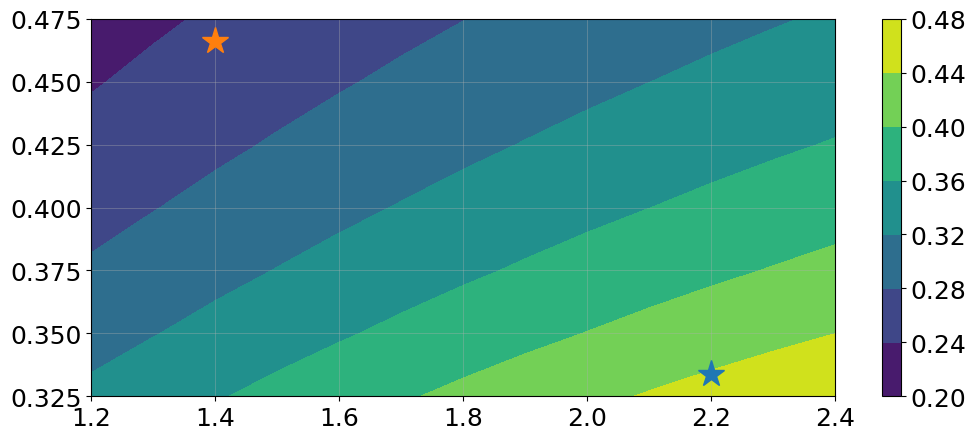

In [367]:
plt.contourf(M, F, F_W_avail_TOC/F)
plt.plot([2.2], [0.334], '*', markersize=20)
plt.plot([1.4], [0.466], '*', markersize=20)
plt.colorbar()

In [330]:
F00_W.T.shape

(1, 7)

In [ ]:
if True:
# Normalize trajectories 
    T = dict()
    X = dict()
    Z = dict()
    V = dict()
    G = dict()
    A = dict()

    for k, case in enumerate(case_lst): 

        T[case] = np.zeros((np.size(W_S_lst)*np.size(F_W_lst), 100))
        X[case] = np.zeros((np.size(W_S_lst)*np.size(F_W_lst), 100))
        Z[case] = np.zeros((np.size(W_S_lst)*np.size(F_W_lst), 100))
        V[case] = np.zeros((np.size(W_S_lst)*np.size(F_W_lst), 100))
        G[case] = np.zeros((np.size(W_S_lst)*np.size(F_W_lst), 100))
        A[case] = np.zeros((np.size(W_S_lst)*np.size(F_W_lst), 100))

        cntr = -1
        for i,W_S in enumerate(W_S_lst):
            for j,F_W in enumerate(F_W_lst):

                cntr += 1

                x_group     = F_W / W_S * clmax_lst[case]
                t_group     = F_W / np.sqrt(W_S/clmax_lst[case])
                z_group     = clmax_lst[case]/(F_W*W_S) / np.sqrt(LDmax_lst[case])
                v_group     = 1/np.sqrt(W_S/clmax_lst[case])
                gamma_group = (np.pi/180)*1/F_W**2 / np.sqrt(LDmax_lst[case])

                T[case][cntr,:] = np.linspace(0, 0.95, 100)   

                fx = interpolate.interp1d(data[case][W_S][F_W]['t_source [s]']*t_group, data[case][W_S][F_W]['X [m]']*x_group, fill_value='extrapolate')
                fz = interpolate.interp1d(data[case][W_S][F_W]['t_source [s]']*t_group, data[case][W_S][F_W]['Z [m]']*z_group, fill_value='extrapolate')
                fv = interpolate.interp1d(data[case][W_S][F_W]['t_source [s]']*t_group, data[case][W_S][F_W]['V [m/s]']*v_group, fill_value='extrapolate')
                fg = interpolate.interp1d(data[case][W_S][F_W]['t_source [s]']*t_group, data[case][W_S][F_W]['gamma [deg]']*gamma_group, fill_value='extrapolate')
                fa = interpolate.interp1d(data[case][W_S][F_W]['t_source [s]']*t_group, data[case][W_S][F_W]['alpha [deg]'], fill_value='extrapolate')

                X[case][cntr,:] = fx(T[case][cntr,:])
                Z[case][cntr,:] = fz(T[case][cntr,:])
                V[case][cntr,:] = fv(T[case][cntr,:])
                G[case][cntr,:] = fg(T[case][cntr,:])
                A[case][cntr,:] = fa(T[case][cntr,:])
    
    
    fig, ax = plt.subplots(2, 2, figsize=(20,7))
    plt.style.use('../utils/plot.mplstyle')

    color_lst = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    linestyle = ['-', '--', 'o', '.-']

    labels = ['$c_{L,max}=1.19$, $c_L = f(c_D)$', 
              '$c_{L,max}=1.19$, $c_L/c_D = 6.7$',
              '$c_{L,max}=1.19$, $c_L/c_D = 13.4$',
              '$c_{L,max}=1.45$, $c_L/c_D = 6.7$ ']

    # Plot microphones
    for k,case in enumerate(case_lst):

        for i,W_S in enumerate(W_S_lst):

            for j,F_W in enumerate(F_W_lst):

                x_group = F_W / W_S * clmax_lst[case_lst[k]]
                z_group = clmax_lst[case_lst[k]]/(F_W*W_S) / np.sqrt(LDmax_lst[case_lst[k]])

                # Plot closest distance to microphone
                m = np.tan(0.387)
                b = -0.22*m
                x_mic = 6500*x_group
                x_int = (1/m*x_mic-b)/(m+1/m)
                y_int = m*x_int+b    

    #             if k == 2 and i == 0 and j == 0:
    #                 ax[0,0].plot([x_mic, x_int], [0, y_int], ':', color='darkgrey', label='$r_{min}$ between trajectory and microphone')
    #             else:
    #                 ax[0,0].plot([x_mic, x_int], [0, y_int], ':', color='darkgrey')

                # Plot microphone
                if k == 0 and i == 0 and j == 0:
                    ax[0,0].plot(6500*x_group, 0.*np.ones(np.size(x_group)), 'o', color='grey', markersize=5, markeredgecolor='k', label='Flyover microphone')
                else:
                    ax[0,0].plot(6500*x_group, 0.*np.ones(np.size(x_group)), 'o', color='grey', markersize=5, markeredgecolor='k')

    # Scaling of the altitude
    for i,case in enumerate(case_lst):
        ax[0,0].fill_between(np.max(X[case], axis=(0)), np.min(Z[case], axis=(0)), np.max(Z[case], axis=(0)), color=color_lst[i], alpha=0.4, label=labels[i])
        if i == 0:
            ax[0,0].plot([0, 0.22, 1.5], [0, 0, 1.28*np.tan(0.387)], 'k--', label='Normalized trajectory')
        ax[0,0].set_xlim([0,1.5])
        ax[0,0].set_xlabel('$X^*$')
        ax[0,0].set_ylabel('$Z^*$')

        ax[0,1].fill_between(np.max(T[case], axis=(0)), np.min(V[case], axis=(0)), np.max(V[case], axis=(0)), color=color_lst[i], alpha=0.4)
        ax[0,1].set_xlim([0,0.95])
        ax[0,1].set_xlabel('$t^*$')
        ax[0,1].set_ylabel('$V^*$')

        ax[1,0].fill_between(np.max(T[case], axis=(0)), np.min(G[case], axis=(0)), np.max(G[case], axis=(0)), color=color_lst[i], alpha=0.4)
        ax[1,0].set_xlim([0,0.95])
        ax[1,0].set_xlabel('$t^*$')
        ax[1,0].set_ylabel(r'$\gamma^*$')
        ax[1,0].plot([0, 1.5], [0.387, 0.387], 'k--')

        ax[1,1].fill_between(np.max(T[case], axis=(0)), np.min(A[case], axis=(0)), np.max(A[case], axis=(0)), color=color_lst[i], alpha=0.4)
        ax[1,1].set_xlim([0,0.95])
        ax[1,1].set_xlabel('$t^*$')
        ax[1,1].set_ylabel(r'$\alpha^*$')

    ax[0,0].legend(loc='lower left', bbox_to_anchor=(0, 1.02), frameon=False)

    plt.subplots_adjust(hspace=0.35, wspace=0.2)